# 2025-04-08 Multigrid

## Last time

* Preconditioning building blocks
* Domain decomposition

## Today

* Project pitches
* Multigrid
  * Spectral perspective
  * Factorization perspective


In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Geometric multigrid and the spectrum

* Multigrid uses a hierarchy of scales to produce an operation "$M^{-1}$" that can be applied in $O(n)$ ("linear") time such that 
$$\lVert I - M^{-1} A \rVert \le \rho < 1$$
independent of the problem size.
* We'll consider the one dimensional Laplacian using the stencil
$$ \Big(\frac{h^2}{2}\Big) \frac{1}{h^2} \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} $$

In [2]:
function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A)
end

laplace1d (generic function with 1 method)

L[1:2] = [0.00048371770801235576, 0.0019344028664056293]
L[end - 1:end] = [1.9980655971335943, 1.999516282291988]


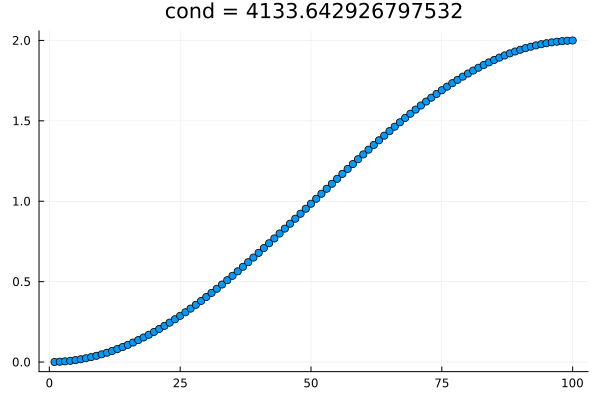

In [3]:
x, A = laplace1d(100)
#@show A[1:4,1:4]
L, X = eigen(A)
@show L[1:2]
@show L[end-1:end]
scatter(L, title="cond = $(L[end]/L[1])", legend=:none)

# What do the eigenvectors look like?

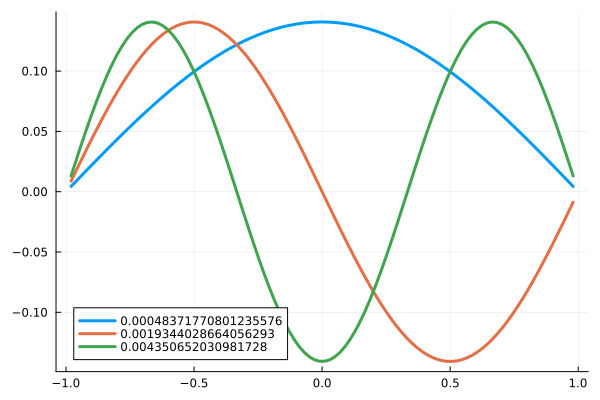

In [4]:
x, A = laplace1d(100)
L, X = eigen(A)
plot(x, X[:,1:3], label=L[1:3]', legend=:bottomleft)

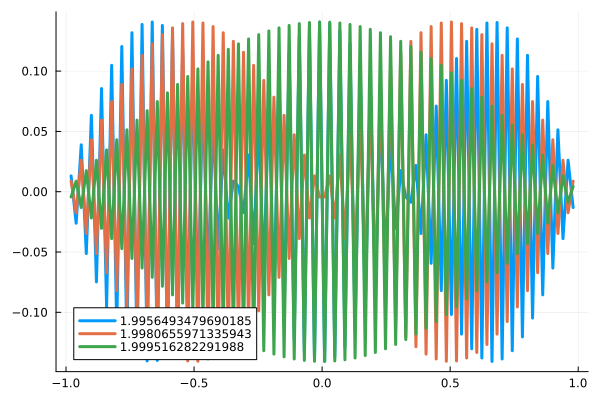

In [5]:
plot(x, X[:, end-2:end], label=L[end-2:end]', legend=:bottomleft)

# Condition number with grid refinement

**Question**: Based on how the minimal eigenvalue changes, how does the condition number change with grid refinement?

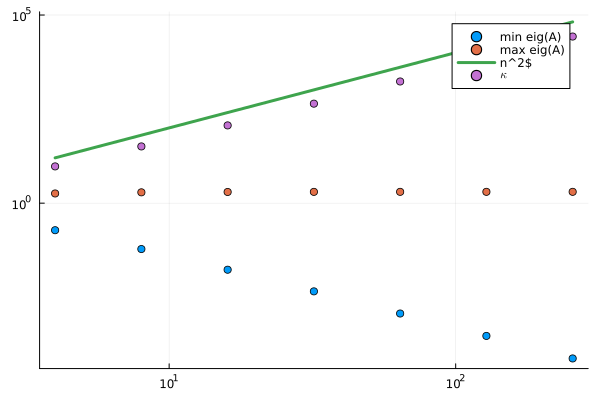

In [6]:
ns = 2 .^ (2:8)
eigs = vcat([eigvals(laplace1d(n)[2])[[1, end]] for n in ns]'...)
conds = vcat([cond(laplace1d(n)[2]) for n in ns]'...)

scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> n^2, label="n^2\$", xscale=:log10, yscale=:log10)
scatter!(ns, conds, label="\$\\kappa\$", xscale=:log10, yscale=:log10)

# Fourier analysis perspective

* Consider the basis $\phi(x, \theta) = e^{i \theta x}$. 
* **Question**: If we have a discrete signal $\{x_i\}_{i=1}^n = x_1, x_2, \ldots, x_n$, what does the highest frequency, amplitude-1 signal possible look like?

* It would be $1, -1, 1, -1, \ldots$. Therefore 
* If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

* Symbol recap: Let $\phi(x, \theta) = e^{i\theta x}$ be an input signal we apply the stencil (i.e. differentiation rule = nodes + weights) $S$ to, e.g. 
$$ S\phi(x, \theta) = s_{-1}\phi(x-1, \theta) + s_0\phi(x, \theta) + s_1\phi(x+1, \theta) := \hat{S}(\theta) \phi(x, \theta)   $$
* Then $\hat{S}(\theta)$ is the symbol. 
* **Question**: what are the eigenvalues?

In [7]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

plot_symbol (generic function with 2 methods)

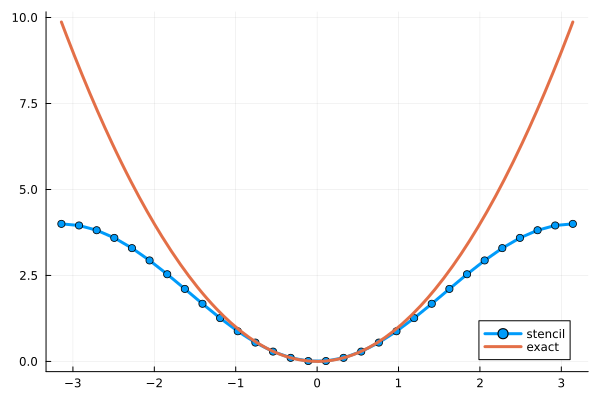

In [8]:
plot_symbol([1 -2 1])
#plot!(xlims=(-1, 1))